This notebook achieves several things.
1) It combines the Bonsai output of 470nm and 415nm traces into one side-by-side sheet
2) It crops to a start and end time 
3) It fits the 470 to the 415 curve, plots these
4) It subtracts fitted 470 from fitted 415 for the deltaF
5) It has the user define a baseline period (start and end in seconds)
6) It calculates the median of this baseline and subtracts this from the entire trace
7) It calculates a % change in dF/F0
8) It calculates a Z-score

Haven't done these bits yet
9) It lets the user define how many relevant bins of information are in the trace, e.g. Baseline, Saline i.p., oxytocin i.p., and when they start/end.
10) It graphs the trace with these bins demarkated
11) It calculates the mean and max %chagne and Z-score in each bin (and AUC?)


In [36]:
# Import dependencies
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import array as arr
import scipy
from scipy import signal as ss
from matplotlib.pyplot import figure


<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

# 1) Combine the Bonsai output of 470nm and 415nm traces into one side-by-side sheet, crop to start/end, and plot the traces with a raw delta

In [2]:
# Input start time and duration of TOTAL recording in seconds, for cropping
# Change to take input as frame number
StartSecs = 180 ## if using this for peri-event, keep at 0. it will cut the file to this point. 
DUR = 3600 ## in seconds. make it at least your session, can be longer
Hz = 20 ## Capture rate on NPM system for the 470nm channel

StartFrame = int((StartSecs*Hz)+1)
EndFrame = DUR*Hz + StartFrame
print("StartFrame is: ",StartFrame)
print("EndFrame is: ",EndFrame)

StartFrame is:  3601
EndFrame is:  75601


470 file is:  ['C:\\Users\\61447\\Documents\\Tempfiles\\MiaNewFiles\\Demo\\Single-folder-test\\m19_470_2021-07-19T11_35_42.csv']
415 file is:  ['C:\\Users\\61447\\Documents\\Tempfiles\\MiaNewFiles\\Demo\\Single-folder-test\\m19_415_2021-07-19T11_35_42.csv']
Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_RawTraces.svg


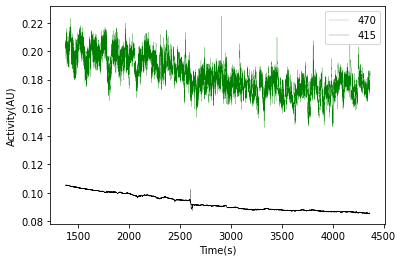

In [4]:
#GETS 470nm and 415nm in separate dataframes
#INPUT YOUR FOLDER HERE
path = r'C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test' # use your path

#Makes a new folder to save files in to
savepath = os.path.join(path,"Pre-processing")
if not os.path.exists(savepath):
    os.mkdir(savepath)
    
#finds the 470 and 415 files in the oriignal folder
df470path = glob.glob(path + "/*470*.csv")
print("470 file is: ", df470path)
df415path = glob.glob(path + "/*415*.csv")
print("415 file is: ", df415path)

## Extracts animalID from filename of df470path
str = ''.join(df470path)
AnimalID = str.split('\\')[-1].split('_')[0]


## Gets info from 470nm sheet and crops to start time
cols470 = ['FrameCounter', 'Timestamp', 'Region0G']
csv470 = pd.read_csv(df470path[0], skiprows = range(1,StartFrame), usecols=cols470, )
# puts that into a dataframe
df470=pd.DataFrame(csv470.values, columns = ["Frame", "Timestamp", "470nm"])
#crops to end frame
df470 = df470[:EndFrame] 
#df470

## Gets only the 415nm trace from 415nm sheet
cols415 = ['Region0G']
csv415 = pd.read_csv(df415path[0], skiprows = range(1,StartFrame), usecols=cols415)
# puts that into a dataframe
df415=pd.DataFrame(csv415.values, columns = ["415nm"])
#crops to end frame
df415 = df415[:EndFrame] 
#df415

# Combines the two dataframes so 470/415 are side-by-side
combinedone=pd.concat([df470,df415], axis=1)
#combinedone

# Plot and save the trace you've segmented for delta, 470 and 415. For Delta only, use below function

x = combinedone['Timestamp']
y1 = combinedone['470nm']
y2 = combinedone['415nm']

plt.plot(x, y1, color='green', linewidth=0.2, label = "470")
plt.plot(x, y2, color='black', linewidth=0.2, label = "415")
plt.legend(['470', '415'], loc='best')
plt.xlabel('Time(s)')
plt.ylabel('Activity(AU)')

## Save the above plot, input what you want to call it
#filename = input("Save as what? ")
#current_path = os.getcwd()
## Save the above plot
plt.savefig(savepath+'/'+AnimalID + "_" + "_RawTraces.svg", dpi=600, orientation='landscape')

print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_RawTraces.svg"))

plt.show()

# Write combinedone df to csv, using animal ID
#combinedone.to_csv(savepath+'/'+AnimalID + "_RawTraces.csv", encoding='utf-8')
#print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_RawTraces.csv"))






# 2) Fit 470 to 415 curve

In [6]:
##### For now, if they are uneven # of frames, you'll need to manually remove the last frame from the one with the highest
#### Adjust this to take these values from the newly created m19_rawtraces.csv
signal = df470['470nm']
control = df415['415nm']


print("Signal, number of frames: ",signal.shape)
print("Control, number of frames: ",control.shape)

Signal, number of frames:  (59826,)
Control, number of frames:  (59826,)


Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_NormalisedTrace.svg


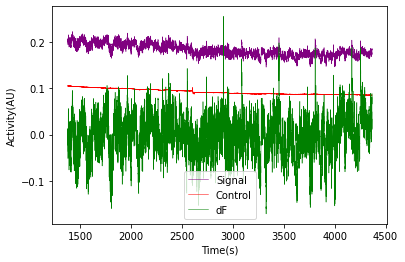

,Frame,Timestamp,470nm,415nm,norm_data
0,7201.0,1376.237216,0.205636,0.105393,0.001578
1,7203.0,1376.287232,0.205664,0.105292,0.002561
2,7205.0,1376.337216,0.205522,0.105278,0.001983
3,7207.0,1376.387232,0.203970,0.105186,-0.004819
4,7209.0,1376.437216,0.204644,0.105509,-0.004217
...,...,...,...,...,...
59821,126843.0,4367.322112,0.184841,0.085452,0.079925
59822,126845.0,4367.372096,0.185450,0.085524,0.082708
59823,126847.0,4367.422112,0.184870,0.085412,0.080530
59824,126849.0,4367.472096,0.185838,0.085444,0.085844


In [19]:
## Conducts polyfit on control, and applies it to signal channel
def controlFit(control, signal):
    p = np.polyfit(control, signal, 1)
    arr = (p[0]*control)+p[1]
    return p,arr


#controlFit(control,signal)

## Subtracts fitted control from fitted signal
### Nick to check if im still using this dFF stuff, or if im only using norm_data
def deltaFF(signal, control):
    res = np.subtract(signal, control)
    normData = np.divide(res, control)
    deltaFF = normData
    #normData = normData*100
    return deltaFF

deltaFF(signal, control)


p,control_fit = controlFit(control, signal)
norm_data = deltaFF(signal, control_fit)
norm_data ## This is the most important thing, look at how this variable is calculated
    
# Plot and save the trace you've segmented for delta, 470 and 415. For Delta only, use below function

x = combinedone['Timestamp']
y1 = signal
y2 = control
y3 = norm_data
y4 = p
#y4 = combinedone['470nm']

plt.plot(x, y1, color='purple', linewidth=0.5, label = "Signal")
plt.plot(x, y2, color='red', linewidth=0.5, label = "Control")
plt.plot(x, y3, color='green', linewidth=0.5, label = "dF")
plt.plot(x, p[0]*)
#plt.plot(x, y4, color='orange', linewidth=0.5, label = "p")
#plt.plot(x, y4, color='orange', linewidth=0.2, label = "rawsignal")
plt.legend(['Signal', 'Control', 'dF'], loc='best')
plt.xlabel('Time(s)')
plt.ylabel('Activity(AU)')

## Save the above plot, input what you want to call it
#filename = input("Save as what? ")
#current_path = os.getcwd()
## Save the above plot
plt.savefig(savepath+'/'+AnimalID + "_" + "_NormalisedTrace.svg", dpi=600, orientation='landscape')

print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_NormalisedTrace.svg"))

plt.show()

## Saves normalised data into a sheet with the raw data too
norm_data=pd.DataFrame(norm_data, columns = ["norm_data"])
norm_data
# Combines the dataframes so raw and normalised data are together
combinedtwo=pd.concat([combinedone,norm_data], axis=1)
combinedtwo


# Write combinedtwo df to csv, using animal ID
#combinedtwo.to_csv(savepath+'/'+AnimalID + "_NormalisedTraces.csv", encoding='utf-8')
#print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_NormalisedTraces.csv"))

c:\users\61447\miniconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


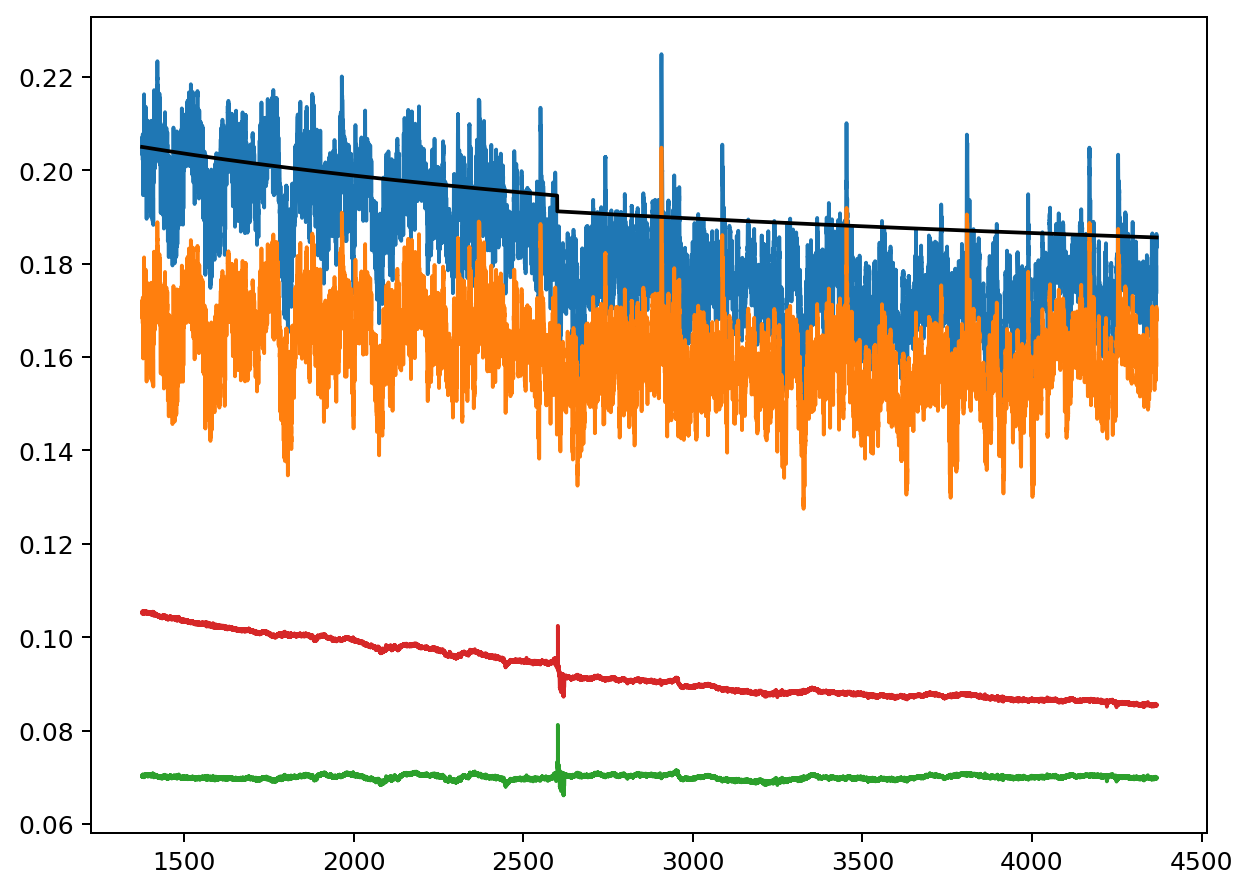

In [95]:
from scipy.optimize import curve_fit
figure(figsize=(8,6), dpi=180)
# plt.plot(x, control)
def func(x, a, b, c):
    return a*np.log(b*x)+c

###In case of chaotic event

popt, pcov = curve_fit(func, x[x<2500], control[x<2500])
fitline = func(x[x<2600], *popt)

# plt.plot(x, func(x, *popt))
popt, pcov = curve_fit(func, x[x>2700], control[x>2700])
post_fitline = func(x[x>2600], *popt)
combined_fitline = pd.concat((fitline, post_fitline))
plt.plot(x, signal)
plt.plot(x, (signal-combined_fitline)+0.07)

plt.plot(x, (control - combined_fitline)+0.07)
plt.plot(x, control )
plt.plot(x, combined_fitline+0.1, color='black' ) 


plt.show()



c:\users\61447\miniconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


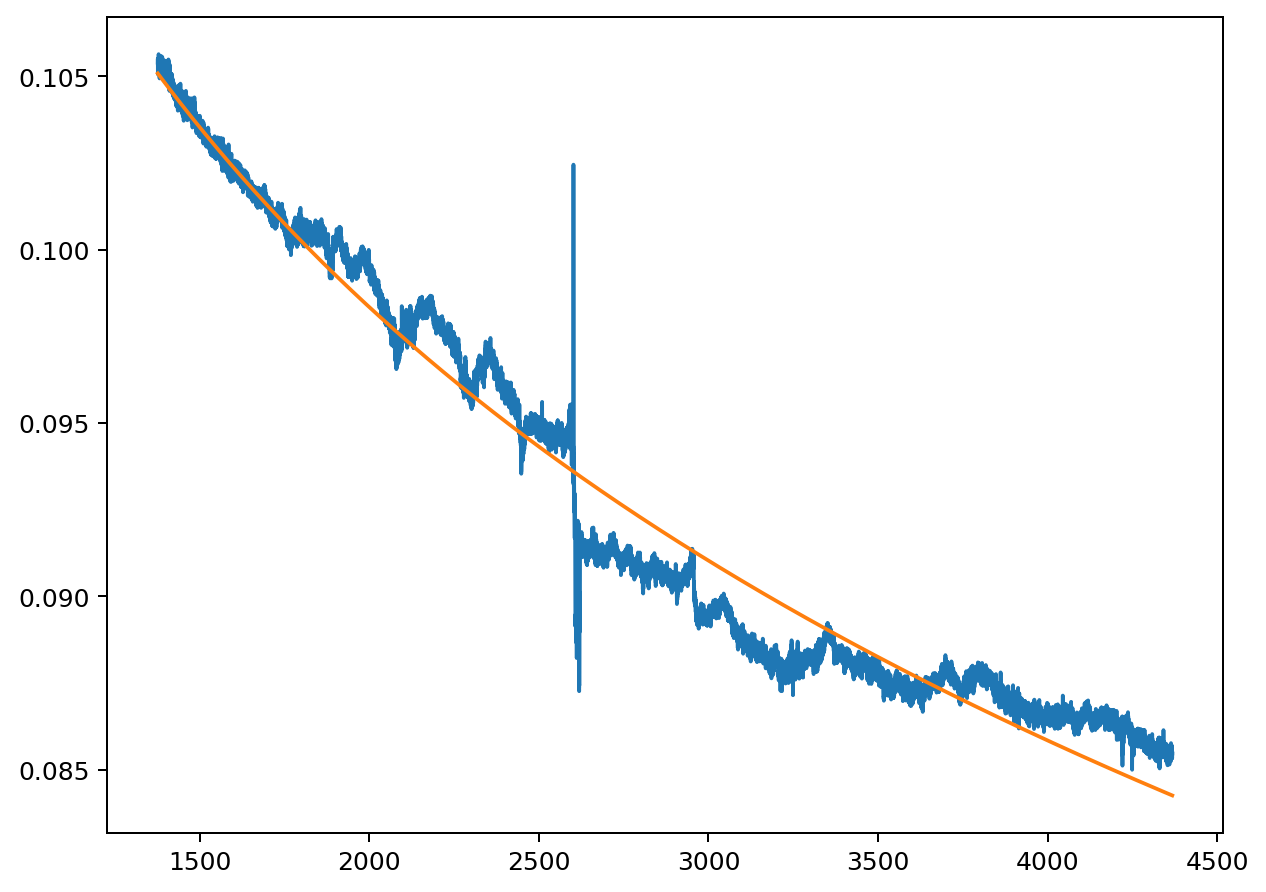

In [69]:
from scipy.optimize import curve_fit
figure(figsize=(8,6), dpi=180)
plt.plot(x, control)
def func(x, a, b, c):
    return a*np.log(b*x)+c

###In case of chaotic event

popt, pcov = curve_fit(func, x, control)
fitline = func(x, *popt)

plt.plot(x, fitline)
plt.show()



In [64]:
x[x<2500]

0        1376.237216
1        1376.287232
2        1376.337216
3        1376.387232
4        1376.437216
            ...     
22471    2499.798624
22472    2499.848608
22473    2499.898624
22474    2499.948608
22475    2499.998624
Name: Timestamp, Length: 22476, dtype: float64

In [65]:
x[x>2500]

22476    2500.048608
22477    2500.098624
22478    2500.148608
22479    2500.198624
22480    2500.248608
            ...     
59821    4367.322112
59822    4367.372096
59823    4367.422112
59824    4367.472096
59825    4367.522112
Name: Timestamp, Length: 37350, dtype: float64

In [20]:
p

array([1.71262851, 0.02481277])

# 3) Define Baseline period, removes it from dF to get dF-f0, to be used for %dF-F0/F0 and z-scores


In [9]:
# GEt this data from hand annotated frame # of baseline start, then decide how long your baseline period is
StartofBaseline = 5155  # input frame number see if i can make this take timestamp from the csv
BaselineDur = 15 ## input duration in minutes
BaselineDurFrame = BaselineDur*Hz*60

In [7]:
# Make an option to take NS entry time, minus X minus, as the baseline start time

In [11]:
# As in step 1 you have defined the start point, this takes that into consideration
BaselineStartFrame = StartofBaseline - StartFrame
#print(BaselineStartFrame)
BaselineFinalFrame = BaselineDurFrame + BaselineStartFrame

## Defines Fzero
dfBase = pd.DataFrame(norm_data)
dfBase = dfBase[BaselineStartFrame:BaselineFinalFrame] 
#print(dfBase)
#Fzero or F0 is the median of the defined baseline period. this is for subtracting from each dF value
Fzero = dfBase.median()
print("Baseline Fluorescence [Fzero] is: ", Fzero)

# Calculates dF-Fzero
dfminusbaseline = norm_data - Fzero

dfminusbaseline=pd.DataFrame(dfminusbaseline.values, columns = ["dF-Fzero"])
#print("df minus baseline is", dfminusbaseline)

# Combines the two dataframes so 470/415 are side-by-side
combinedthree=pd.concat([combinedtwo, dfminusbaseline], axis=1)
#combinedthree


Baseline Fluorescence [Fzero] is:  norm_data    0.005884
dtype: float64


# 4) Uses dF-Fzero to calculate %dF  as (dF-F0/F0) and z-score


C:\Users\61447\AppData\Local\Temp/ipykernel_2556/3296345425.py:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  pctdFF = np.divide(dfminusbaseline, Fzero)


Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_pctdF.svg


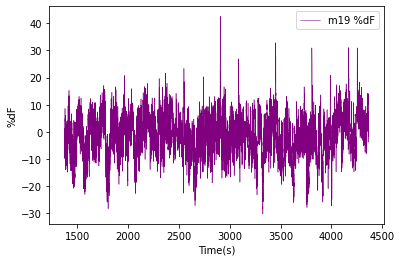

Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_Z-score.svg


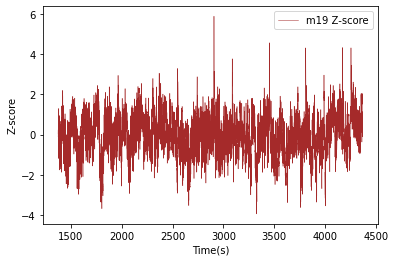

Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_SignalZscore.csv
Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_SignalPercentDelta.csv


In [12]:
#Fzero is defined above, as is dfminusebaseline
pctdFF = np.divide(dfminusbaseline, Fzero)
pctdFF = pctdFF.rename(columns={'dF-Fzero': 'pctdFF'})
pctdFF

# Plot and save the trace you've segmented for delta, 470 and 415. For Delta only, use below function

x = combinedthree['Timestamp']
y1 = pctdFF


plt.plot(x, y1, color='purple', linewidth=0.5, label = "%dF")
plt.legend([AnimalID+' %dF'], loc='best')
plt.xlabel('Time(s)')
plt.ylabel('%dF')


## Save the above plot
plt.savefig(savepath+'/'+AnimalID + "_" + "_pctdF.svg", dpi=600, orientation='landscape')

print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_pctdF.svg"))

plt.show()




### calculates z-score

ZdF = scipy.stats.zscore(dfminusbaseline, axis=0, ddof=0, nan_policy='propagate')
ZdF = ZdF.rename(columns={'dF-Fzero': 'Z-score'})

# Plot and save the trace you've segmented for delta, 470 and 415. For Delta only, use below function

x = combinedthree['Timestamp']
y1 = ZdF


plt.plot(x, y1, color='brown', linewidth=0.5, label = "Z-score")
plt.legend([AnimalID+' Z-score'], loc='best')
plt.xlabel('Time(s)')
plt.ylabel('Z-score')

## Save the above plot, input what you want to call it
#filename = input("Save as what? ")
#current_path = os.getcwd()
## Save the above plot
plt.savefig(savepath+'/'+AnimalID + "_" + "_Z-score.svg", dpi=600, orientation='landscape')

print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_Z-score.svg"))

plt.show()


## SAVES FINAL OUTPUT CSV to be used with other tools
# f = final

fTimestamp = combinedthree['Timestamp']
fFrame = combinedthree['Frame']
f470 = combinedthree['470nm']
f415 = combinedthree['415nm']

# Write FinalOutput to csv, using animal ID
#FullOutput=pd.concat([fFrame, fTimestamp, f470, f415, pctdFF, ZdF], axis=1)
#FullOutput.to_csv(savepath+'/'+AnimalID + "_FullOutput.csv", encoding='utf-8', index=False)
#print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_FullOutput.csv"))

# Write zscore, timestmap, frame to csv for peri-event
ZdF = ZdF.rename(columns={'Z-score': 'signal'})
SignalZscore=pd.concat([fFrame, fTimestamp, ZdF], axis=1)
SignalZscore.to_csv(savepath+'/'+AnimalID + "_SignalZscore.csv", encoding='utf-8', index=False)
print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_SignalZscore.csv"))

# Write zscore, timestmap, frame to csv for peri-event
pctdFF = pctdFF.rename(columns={'pctdFF': 'signal'})
SignalPercentDelta=pd.concat([fFrame, fTimestamp, pctdFF], axis=1)
SignalPercentDelta.to_csv(savepath+'/'+AnimalID + "_SignalPercentDelta.csv", encoding='utf-8', index=False)
print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_SignalPercentDelta.csv"))


# 5) This combines your behaviour and cameracsv into one sheet for the peri-event

In [13]:
#GETS 470nm and 415nm in separate dataframes

morlogpath = glob.glob(path + "/*morlog*.csv")
print("morlog file is: ", morlogpath)
camerapath = glob.glob(path + "/*csvforvideo*.csv")
print("camera timestamps file is: ", camerapath)

## Gets info from morlog behaviour sheet, and camera sheet, and collates them
behaviourcols = ['frame', 'behaviour', 'hits']
behaviourcsv = pd.read_csv(morlogpath[0], usecols=behaviourcols)

# puts that into a dataframe
dfbehaviour=pd.DataFrame(behaviourcsv.values, columns = ["frame", "duration", "hits"])

# Gets info from morlog behaviour sheet, and camera sheet, and collates them
cameratimestamps = pd.read_csv(camerapath[0], header=None, usecols=[0])

# puts that into a dataframe
dfcameratimestamps=pd.DataFrame(cameratimestamps.values, columns = ["Timestamp"])

# Combines the two dataframes so behaviour frames and camera timestmaps are side-by-side
behaviourtimestamped=pd.concat([dfbehaviour,dfcameratimestamps], axis=1)

# Write combinedone df to csv, using animal ID
behaviourtimestamped.to_csv(savepath+'/'+AnimalID + "_BehaviourTimeStamped.csv", encoding='utf-8', index=False)
print('Success! Saved as {}'.format(savepath+'/'+AnimalID + "_BehaviourTimeStamped.csv"))

morlog file is:  ['C:\\Users\\61447\\Documents\\Tempfiles\\MiaNewFiles\\Demo\\Single-folder-test\\m19_morlog_scored_behaviour.csv']
camera timestamps file is:  ['C:\\Users\\61447\\Documents\\Tempfiles\\MiaNewFiles\\Demo\\Single-folder-test\\m19_csvforvideo_2021-07-19T11_35_41.csv']
Success! Saved as C:\Users\61447\Documents\Tempfiles\MiaNewFiles\Demo\Single-folder-test\Pre-processing/m19_BehaviourTimeStamped.csv
